In [1592]:
import pandas as pd
import numpy as np
import re

import sys

sys.path.append("../src/biblical_scripts/pipelines/data_science")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

from AuthorshipAttribution.AuthAttLib import *

from tqdm import tqdm

import logging
logging.basicConfig(level=logging.INFO)

In [1593]:
project_dir = "/Users/kipnisal/DS/BiblicalScripts/bib-scripts"

from kedro.framework.context import load_context
cnx = load_context(project_dir)

from kedro.config import ConfigLoader

conf_paths = [path +'/'+ "conf/base",path +'/'+ "conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

conf_paths = [path + '/' + "conf/base",path + '/' + "conf/local"]
conf_loader = ConfigLoader(conf_paths)
parameters = conf_loader.get("parameters*", "parameters*/**")


/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:663: DeprecationWarning: `kedro.framework.context.load_context` is now deprecated in favour of `KedroSession.load_context` and will be removed in Kedro 0.18.0.
INFO:anyconfig:Loading: /Users/kipnisal/DS/BiblicalScripts/bib-scripts/pyproject.toml
INFO:anyconfig:Loading: /Users/kipnisal/DS/BiblicalScripts/bib-scripts/conf/base/catalog.yml
INFO:anyconfig:Loading: /Users/kipnisal/DS/BiblicalScripts/bib-scripts/conf/base/parameters.yml


# Distributed

### To Do:
 - Report accuracy of sim_null and BS
 - Add CI from BS
 - Make sure 

In [1252]:
from dask.distributed import Client

In [1253]:
client = Client()

DEBUG:asyncio:Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector


# Text Processing

In [747]:
data = pd.read_csv(path + '/' + 'data/02_intermediate/oshd_parsed.csv')
from biblical_scripts.pipelines.data_engineering.TextProcessing import TextProcessing
tp = TextProcessing(extract_prefix=True, ng_range=(2,2))
data_proc = tp.proc_ng(data)

INFO:root:Extracting prefixes and suffixes
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

# Conversion

In [936]:
from biblical_scripts.extras.Convert import Convert
convert = Convert(data)

In [937]:
convert.to_term(('120', '1456'))

['אָדָ֣ם', 'גֵּהָ֑ה']

In [939]:
vocab = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/05_model_input/vocabulary.csv")

In [1025]:
from sklearn.model_selection import KFold

In [961]:
vocab.loc[1,'feature']

"('c', '<Np>')"

# Sim null  

In [1578]:
sim_null_res_BS = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/07_sim_output/sim_null_res_BS.csv")
sim_null_res = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/07_sim_output/sim_null_res.csv")
print("len res = ",len(sim_null_res))
print("len res BS = ", len(sim_null_res_BS))

[autoreload of biblical_scripts.pipelines.bootstrap.pipeline failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src/bibl

len res =  3074
len res BS =  30740


## Results:

In [1579]:
import plotnine
plotnine.options.figure_size = (10, 6)
from plotnine import *
logging.basicConfig(level=logging.INFO)

In [1588]:
from biblical_scripts.pipelines.report.nodes import _prepare_res

In [1678]:
def evaluate_accuracy_BS(df : pd.DataFrame, params_report) -> pd.DataFrame :
    """
    Indicate whetehr minimal discripancy is obtained by the true author.
    
    Args:
    df      data of discripancy results in columns 'value'. 
    params_report       parameters
    
    Returns:
    res     one row per doc_id. Indicate whether minimal discripancy is           obtained by the true author.
    """
    
    def _eval_succ(df) :
        idx_min = df.groupby(['doc', 'itr_BS'])['value'].idxmin()
        res_min = df.loc[idx_min, :].rename(columns={'corpus' : 'most_sim'})
        res_min.loc[:, 'succ'] = res_min.true_author == res_min.most_sim
        res_min['acc'] = res_min.groupby('itr_BS').succ.transform('mean')
        return res_min

    value = params_report['value']
    df1 = df[df['variable'].str.contains(f":{value}")]
    df1 = df1.reset_index()

    res = _eval_succ(df1)
    return res

In [1693]:
from typing import List
def _add_stats_BS(data : pd.DataFrame, value : str, by : List) -> pd.DataFrame :
    """
    Add std and CI of BS iterations
    """
    grp = data.groupby(by)
    res = grp.agg({value : ['mean','std',
                               lambda x : pd.Series.quantile(x, q=.05),
                               lambda x : pd.Series.quantile(x, q=.95)
                              ]}, as_index=False).reset_index()

    res[f'{value}_mean'] = res[(value, 'mean')]
    res[f'{value}_std'] = res[(value, 'std')]
    res[f'{value}_CI05'] = res[(value, '<lambda_0>')]
    res[f'{value}_CI95'] = res[(value, '<lambda_1>')]
    res = res.drop(value, axis=1, level=0)
    
    return res


In [1699]:
_add_stats_BS(res, value = 'value', by = ['doc', 'corpus'])

,doc,corpus,value_mean,value_std,value_CI05,value_CI95
,,,,,,
0,1Kgs.8 by DtrH,Dtr,4.545449,0.409408,4.036047,5.127634
1,1Kgs.8 by DtrH,DtrH,3.753298,0.470633,3.248575,4.541674
2,1Kgs.8 by DtrH,P,6.495653,0.376202,6.078627,7.087462
3,2Kgs.17 by DtrH,Dtr,2.647899,0.514785,1.847550,3.224332
4,2Kgs.17 by DtrH,DtrH,2.505046,0.363311,2.076190,3.101766
...,...,...,...,...,...,...
154,Lev.8 by P,DtrH,4.767628,0.412575,4.215785,5.232078
155,Lev.8 by P,P,2.633162,0.371388,2.162384,3.129340
156,Lev.9 by P,Dtr,4.263414,0.370916,3.721670,4.696223


In [1705]:
def _eval_succ(df) :
    idx_min = df.groupby(['doc', 'itr_BS'])['value'].idxmin()
    res_min = df.loc[idx_min, :].rename(columns={'corpus' : 'most_sim'})
    res_min.loc[:, 'succ'] = res_min.true_author == res_min.most_sim
    res_min['acc'] = res_min.groupby('itr_BS').succ.transform('mean')
    return res_min

In [1706]:
df = _eval_succ(res)
df

,author,doc_id,len,variable,value,itr,smp_len,most_sim,doc,true_author,itr_BS,wrt_author,succ,acc
866,doc0,1Kgs.8 by DtrH,1679.0,corpus0:HC,3.688097,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,0,corpus0,True,0.754717
4002,doc0,1Kgs.8 by DtrH,1726.0,corpus0:HC,4.150138,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,1,corpus0,True,0.735849
7045,doc0,1Kgs.8 by DtrH,1653.0,corpus0:HC,3.362353,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,2,corpus0,True,0.735849
10120,doc0,1Kgs.8 by DtrH,1601.0,corpus0:HC,3.636152,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,3,corpus0,True,0.830189
13288,doc0,1Kgs.8 by DtrH,1655.0,corpus0:HC,3.519846,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,4,corpus0,True,0.811321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17811,doc0,Lev.9 by P,477.0,corpus0:HC,2.513677,0,NaN,P,Lev.9 by P,P,5,corpus0,True,0.792453
21361,doc0,Lev.9 by P,530.0,corpus0:HC,3.128988,0,NaN,P,Lev.9 by P,P,6,corpus0,True,0.792453
24381,doc0,Lev.9 by P,483.0,corpus0:HC,2.864138,0,NaN,P,Lev.9 by P,P,7,corpus0,True,0.792453
26897,doc0,Lev.9 by P,522.0,corpus0:HC,2.449801,0,NaN,P,Lev.9 by P,P,8,corpus0,True,0.792453


In [1701]:
res = sim_null_res_BS.copy()
res = res[res.author == 'doc0']
res1 = evaluate_accuracy_BS(res, parameters['report'])


,index,author,doc_id,len,variable,value,itr,smp_len,most_sim,doc,true_author,itr_BS,succ,acc
55,866,doc0,1Kgs.8 by DtrH,1679.0,corpus0:HC,3.688097,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,0,True,0.754717
218,4002,doc0,1Kgs.8 by DtrH,1726.0,corpus0:HC,4.150138,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,1,True,0.735849
375,7045,doc0,1Kgs.8 by DtrH,1653.0,corpus0:HC,3.362353,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,2,True,0.735849
534,10120,doc0,1Kgs.8 by DtrH,1601.0,corpus0:HC,3.636152,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,3,True,0.830189
699,13288,doc0,1Kgs.8 by DtrH,1655.0,corpus0:HC,3.519846,0,NaN,DtrH,1Kgs.8 by DtrH,DtrH,4,True,0.811321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,17811,doc0,Lev.9 by P,477.0,corpus0:HC,2.513677,0,NaN,P,Lev.9 by P,P,5,True,0.792453
1107,21361,doc0,Lev.9 by P,530.0,corpus0:HC,3.128988,0,NaN,P,Lev.9 by P,P,6,True,0.792453
1264,24381,doc0,Lev.9 by P,483.0,corpus0:HC,2.864138,0,NaN,P,Lev.9 by P,P,7,True,0.792453
1402,26897,doc0,Lev.9 by P,522.0,corpus0:HC,2.449801,0,NaN,P,Lev.9 by P,P,8,True,0.792453


/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/stats/binning.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may w

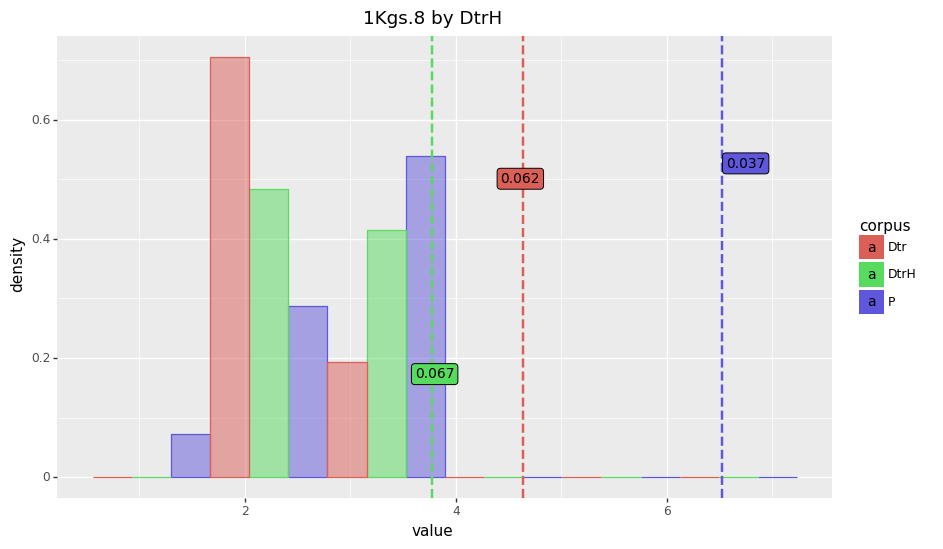

<ggplot: (320465125)>


In [1535]:
res = sim_null_res_BS.copy()
res = add_BS_stats(res)

#res = sim_null_res.copy()
res = add_prob(res)
lo_docs = res.doc.unique()

value = 'HC'
doc_nm = lo_docs[0]

res1 = res[res.variable.str.contains(value)]
res1 = res1[res1.doc == doc_nm] # only data related to tested doc

res1_null = res1[(res1.author == 'doc_smp') & (res1.doc_id != doc_nm)] # only artificially gen'd data 
## >> HERE ()
res1_doc = res1[res1.author == 'doc0']

p = (ggplot(aes(x='value', fill = 'corpus', y='..density..',
            color='corpus', label='corpus'), data = res1_null)
         + geom_histogram(alpha=0.5,position='dodge') 
         #+ geom_density(alpha = 0.5)
         + geom_vline(aes(xintercept='value', color='corpus'),
                      data=res1_doc, size=1, linetype='dashed')
         + geom_label(data=res1_doc,
                          mapping=aes(x='value', y=0.5, label='prob', fill='corpus'),
                          position=position_jitter(),
                          size=10, colour = "black")
         + ggtitle('{}'.format(doc_nm)) )

#p.save('./Figs/simulated_null_{}_NG{}_temp.png'.format(auth,NG_RANGE))
print(p)


/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr

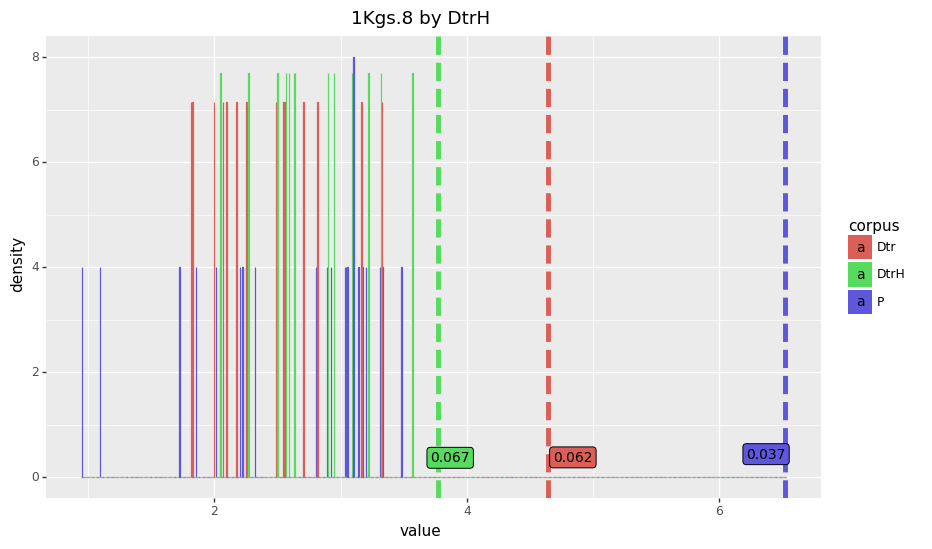

<ggplot: (343879762)>


In [1537]:
p = (ggplot(aes(x='value', fill = 'corpus', y='..density..',
            color='corpus', label='corpus'), data = res1_null)
         + geom_histogram(alpha=0.3,position='dodge', binwidth=.01) 
         #+ geom_density(alpha = 0.5)
         + geom_vline(aes(xintercept='value', color='corpus'),
                      data=res1_doc, size=2, linetype='dashed')
         + geom_label(data=res1_doc,
                          mapping=aes(x='value', y=0.5, label='prob', fill='corpus'),
                          position=position_jitter(),
                          size=10, colour = "black")
         + ggtitle('{}'.format(doc_nm)) )

#p.save('./Figs/simulated_null_{}_NG{}_temp.png'.format(auth,NG_RANGE))
print(p)


# Models

In [1092]:
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')

In [880]:
import pandas as pd
import numpy as np
import logging
%reload_ext autoreload
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.AuthAttLib import AuthorshipAttributionDTM
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.MultiDoc import CompareDocs
from biblical_scripts.pipelines.data_science.nodes import (build_vocab, compute_sim)
#%load_ext autoreload
#%autoreload 2

data_raw = pd.read_csv(path + '/' + 'data/02_intermediate/oshd_parsed.csv')
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')
#vocab = pd.read_csv(path + '/' + 'data/05_model_input/vocabulary.csv')
vocab = build_vocab(data_proc, parameters['vocab'], parameters['known_authors'])

INFO:root:Constructed vocabulary with 960 features


In [878]:
def compute_sim(data, vocabulary, params, known_authors) :
    ds = data.rename(columns = {'feature' : 'term', 'chapter' : 'doc_id'}).dropna()
    model = AuthorshipAttributionDTM(ds, params, vocab=listb(vocabulary.feature.values))
    return model.compute_inter_similarity(LOO = True, wrt_authors=known_authors)

In [ ]:
params = {}; [params.update(p) for p in parameters['model']]

md = CompareDocs(vocabulary=vocab.feature.tolist())
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id', 'chapter']]
ds=ds.rename(columns = {'chapter' : 'doc_id'})
ds['doc_id'] += ' by '
ds['doc_id'] += ds['author'] #sometimes there are multiple authors per chapter
    
known_authors = parameters['known_authors']
train_data = {}
for auth in known_authors :
    train_data[auth] = ds[ds.author==auth]

md.fit(train_data)
df_res1 = pd.DataFrame()
for doc_id in ds.doc_id.unique() :
    tested_doc = ds[ds.doc_id==doc_id]
    auth = tested_doc.author.values[0]
    df_rec = md.test_doc(tested_doc, of_cls = auth)
    r = df_rec.iloc[:,df_rec.columns.str.contains(r'HC|Fisher|chisq')].mean()
    r['doc_id'] = doc_id
    r['author'] = auth
    r['len'] = len(tested_doc)
    df_res1 = df_res1.append(r, ignore_index=True)

In [932]:
df = df_res1.melt(['author', 'doc_id', 'len'])

def _eval_succ(df) :
    df['wrt_author'] = df['variable'].str.extract(r'([^:]+):')
    idx_min = df.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = df.loc[idx_min, :].rename(columns={'wrt_author' : 'most_sim'})
    res_min.loc[:, 'succ'] = res_min.author == res_min.most_sim
    return res_min

value = report_params['value']
df1 = df[df['variable'].str.contains(f":{value}")]
df1 = df1[df1.author.isin(known_authors)].reset_index()

res = _eval_succ(df1)
res['acc'] = res.succ.mean()
res['param'] = str(parameters)

In [935]:
ds = pd.read_csv("../data/05_model_input/vocabulary.csv")
ds[~ds.feature.str.contains(r"\[[a-zA-Z0-9]+\]")]

,feature
0,103
1,1086
2,1104
3,1115
4,1129
...,...
636,8484
637,8519
638,8535
639,887


In [876]:
data_raw[data_raw.chapter == '2Kgs.23']

array(['21, 2 Kings 23 :21-30', 'DtrH'], dtype=object)

# Feature Selection

In [763]:
import pandas as pd
import numpy as np
import logging
%reload_ext autoreload
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.AuthAttLib import AuthorshipAttributionDTM
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.MultiDoc import CompareDocs
from biblical_scripts.pipelines.data_science.nodes import (build_vocab, compute_sim)
#%load_ext autoreload
#%autoreload 2

In [764]:
#data:
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')
vocab = build_vocab(data_proc, parameters['vocab'], parameters['known_authors'])

INFO:root:Constructed a vocabulary of 960 features


In [ ]:
# using discriminating features

md = CompareDocs(vocabulary=vocab.feature.to_list())
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id']]

Dtr = ds[ds.author=='Dtr']
DtrH = ds[ds.author=='DtrH']
P = ds[ds.author=='P']

md.fit({'Dtr' : Dtr, 'DtrH' : DtrH, 'P' : P})
df_disc = md.HCT(stbl=True)
feat = df_disc[df_disc.thresh].index.to_list()
terms = [convert.to_term(f) for f in feat]

In [ ]:
ds = data_proc.drop('term', axis=1).rename(columns = {'chapter' : 'doc_id', 'feature' : 'term'}).dropna()
ds_red = ds[ds.term.isin(feat)]
ds_red[ds_red.groupby('doc_id').term.transform(pd.Series.count)>0]
knwon_authors = parameters['known_authors']
model = AuthorshipAttributionDTM(ds_red, **param, vocab=feat)
df_res=model.compute_inter_similarity(LOO = True, wrt_authors=known_authors)

In [773]:
md = CompareDocs(vocabulary=feat)
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id', 'chapter']]
ds=ds.rename(columns = {'chapter' : 'doc_id'})

known_authors = parameters['known_authors']
train_data = {}
for auth in known_authors :
    train_data[auth] = ds[ds.author==auth]

md.fit(train_data)
df_res1 = pd.DataFrame()
for doc_id in ds.doc_id.unique() :
    tested_doc = ds[ds.doc_id==doc_id]
    auth = tested_doc.author.values[0]
    df_rec = md.test_doc(tested_doc, of_cls = auth)
    r = df_rec.iloc[:,df_rec.columns.str.contains(r'HC|Fisher|chisq')].mean()
    r['doc_id'] = doc_id
    r['author'] = auth
    r['len'] = len(tested_doc)
    df_res1 = df_res1.append(r, ignore_index=True)

DEBUG:root:Processing Dtr...
DEBUG:root:Found 2048 terms.
DEBUG:root:Processing DtrH...
DEBUG:root:Found 2457 terms.
DEBUG:root:Processing P...
DEBUG:root:Found 4179 terms.
DEBUG:root:Doc contains 49.0 terms.
DEBUG:root:Doc contains 119.0 terms.
DEBUG:root:Doc contains 68.0 terms.
DEBUG:root:Doc contains 65.0 terms.
DEBUG:root:Doc contains 60.0 terms.
DEBUG:root:Doc contains 74.0 terms.
DEBUG:root:Doc contains 109.0 terms.
DEBUG:root:Doc contains 175.0 terms.
DEBUG:root:Doc contains 71.0 terms.
DEBUG:root:Doc contains 92.0 terms.
DEBUG:root:Doc contains 175.0 terms.
DEBUG:root:Doc contains 124.0 terms.
DEBUG:root:Doc contains 93.0 terms.
DEBUG:root:Doc contains 62.0 terms.
DEBUG:root:Doc contains 57.0 terms.
DEBUG:root:Doc contains 84.0 terms.
DEBUG:root:Doc contains 91.0 terms.
DEBUG:root:Doc contains 159.0 terms.
DEBUG:root:Doc contains 115.0 terms.
DEBUG:root:Doc contains 136.0 terms.
DEBUG:root:Doc contains 16.0 terms.
DEBUG:root:Doc contains 132.0 terms.
DEBUG:root:Doc contains 59

ValueError: All values in `observed` must be nonnegative.

In [793]:
df_eval = df_res1.melt(['author', 'doc_id', 'len'])
df_eval.head(3)

,author,doc_id,len,variable,value
0,"1, 1 Chron 10",1Chr.10,315.0,Dtr:Fisher,140.932326
1,"2, 1 Chron 11",1Chr.11,761.0,Dtr:Fisher,266.941973
2,Chr1,1Chr.12,387.0,Dtr:Fisher,227.374529


In [792]:
df1 = df[df['variable'].str.contains(f":{value}")]
df1.head(3)

,author,doc_id,len,variable,value,wrt_author
63,"1, 1 Chron 10",1Chr.10,315.0,Dtr:HC,1.161644,Dtr
64,"2, 1 Chron 11",1Chr.11,761.0,Dtr:HC,1.367914,Dtr
65,Chr1,1Chr.12,387.0,Dtr:HC,1.858160,Dtr


In [832]:
known_authors = parameters['known_authors']
report_params = parameters['report']
value = report_params['value']
df = df_eval

#def evaluate_accuracy(df : pd.DataFrame, known_authors : List, report_params, parameters) -> float :
def _eval_acc(df) :
    df['wrt_author'] = df['variable'].str.extract(r'([^:]+):')
    idx_min = res1.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = res1.loc[idx_min, :]
    res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author
    succ_per_doc = res_min.groupby('doc_id').succ.mean()
    return succ_per_doc.mean()

value = report_params['value']
df1 = df[df['variable'].str.contains(f":{value}")]
df1 = df1[df1.author.isin(known_authors)].reset_index()

acc = _eval_acc(df1)

#rep['param'] = parameters
return pd.DataFrame({'acc' : acc}, index=[parameters])


                                                         acc
{'preprocessing': {'extract_prefix': True, 'ext...  0.638554


In [830]:
df1

,index,author,doc_id,len,variable,value,wrt_author
0,124,DtrH,2Kgs.17,520.0,Dtr:HC,2.220364,Dtr
1,125,DtrH,2Kgs.22,568.0,Dtr:HC,3.010700,Dtr
2,313,DtrH,2Kgs.17,520.0,DtrH:HC,0.643856,DtrH
3,314,DtrH,2Kgs.22,568.0,DtrH:HC,1.272487,DtrH
4,502,DtrH,2Kgs.17,520.0,P:HC,3.731762,P
5,503,DtrH,2Kgs.22,568.0,P:HC,3.273535,P


TypeError: reduction operation 'argmin' not allowed for this dtype

In [741]:
df

,author,doc_id,len,variable,value,wrt_author
0,"1, 1 Chron 10",1Chr.10,315.0,HC (Dtr),1.161644,Dtr
1,"2, 1 Chron 11",1Chr.11,761.0,HC (Dtr),1.367914,Dtr
2,Chr1,1Chr.12,387.0,HC (Dtr),1.858160,Dtr
3,"3, 1 Chron 13",1Chr.13,314.0,HC (Dtr),-0.623731,Dtr
4,"4, 1 Chron 14",1Chr.14,309.0,HC (Dtr),1.358312,Dtr
...,...,...,...,...,...,...
577,Prov,Prov.27,316.0,HC (P),2.561318,P
578,Prov,Prov.28,304.0,HC (P),2.202612,P
579,Prov,Prov.29,269.0,HC (P),2.896388,P
580,Prov,Prov.30,412.0,HC (P),3.781481,P


In [687]:
def eval_accuracy(df, known_authors) :
    res1 = df[df.author.isin(known_authors) & df.wrt_author.isin(known_authors)].reset_index()
    idx_min = res1.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = res1.loc[idx_min, :]
    res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author

    succ_per_doc = res_min.groupby('doc_id').succ.mean()
    return succ_per_doc.mean()

df_eval = df_res1.melt(['author', 'doc_id'])
df_eval['wrt_author'] = df_eval['variable'].str.extract(r'HC \((.+)\)')
eval_accuracy(df_eval, known_authors)

0.6385542168674698

In [691]:
eval_accuracy(df_res.rename(columns={'HC' : 'value'}), known_authors)

0.5471698113207547

In [680]:
df_res['len'] = 1000
evaluate_accuracy(df_res, known_authors, 'HC', "")

TypeError: Invalid comparison between dtype=int64 and str

In [677]:
def evaluate_accuracy(df_res: pd.DataFrame, known_authors, min_length_to_report : int, params) -> pd.DataFrame :
    """
    Evaluate accuracy of attribution in min discrepancy manner
    
    Args:
    min_length_to_report    only try to attribute docs of length larger than that
    known_authors           only compare against corpora from this list
    
    Returns:
    average accuracy for each similarity measure
    """
    def prob_of_succ(df, value, known_authors, min_length=min_length_to_report, plot=False) :
        df = df[df.len >= min_length]
        df.loc[:,value] = df[value].astype(float)
        res1 = df[df.author.isin(known_authors) & df.wrt_author.isin(known_authors)].reset_index()
        idx_min = res1.groupby(['doc_id', 'author'])[value].idxmin()
        res_min = res1.loc[idx_min, :]
        res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author

        succ_per_doc = res_min.groupby('doc_id').succ.mean()
        return succ_per_doc.mean()

    res = {}
    for v in ['HC', 'HC_rank', 'chisq', 'chisq_rank', 'log-likelihood','log-likelihood_rank', 'Fisher']  :
        res[v] = prob_of_succ(df_res, value = v, known_authors=known_authors)
        
    res['params'] = str(params)
    return pd.DataFrame(res, index=[0])
